In [ ]:
# Para manter la maquina conectada cuando no se hace nada
while True:
  True

In [ ]:
!pip install emoji

     |████████████████████████████████| 185 kB 8.6 MB/s 
  Created wheel for emoji: filename=emoji-1.4.1-py3-none-any.whl size=186393 sha256=95dd851bcf1faa831a142e6fdb1dee7300d5fc1bbcd6dcbb20e753e71174bad2
  Stored in directory: /root/.cache/pip/wheels/8e/68/ac/537456a5331f1405779f2b3c2a578429d2f6d7419e440330d8
Successfully built emoji


In [ ]:
# Install hugginface transformers
!pip install transformers

     |████████████████████████████████| 2.6 MB 8.7 MB/s 
     |████████████████████████████████| 3.3 MB 24.7 MB/s 
     |████████████████████████████████| 895 kB 61.5 MB/s 
     |████████████████████████████████| 636 kB 66.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# Lista de imports
import pandas as pd
# Descargar datos
from google.colab import files
# Stopwords
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# Removiendo emojis
import emoji
import re
# Modelo
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification # TensorFlow pre-trained model for classification
# Split
from sklearn.model_selection import train_test_split
# Tranformers and Optimizers
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification
from keras.optimizers import Adam

# Datos

In [ ]:
# Para cargar el archivo kaggle.json
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [ ]:
# Bases de datos de Kaggle

# DepressionTweets - https://www.kaggle.com/samrats/depressiontweets
!kaggle datasets download -d samrats/depressiontweets
# English depression related posts from Reddit - https://www.kaggle.com/luizfmatos/reddit-english-depression-related-submissions
!kaggle datasets download -d luizfmatos/reddit-english-depression-related-submissions
# Sentimental Analysis NLP - https://www.kaggle.com/ashishpatel26/sentimental-analysis-nlp?select=neg_tweets.txt
!kaggle datasets download -d ashishpatel26/sentimental-analysis-nlp

# Descomprimiendo archivos y eliminado zip
!unzip -q depressiontweets.zip -d .
!rm depressiontweets.zip
!unzip -q sentimental-analysis-nlp.zip -d .
!rm sentimental-analysis-nlp.zip
!unzip -q reddit-english-depression-related-submissions.zip -d .
!rm reddit-english-depression-related-submissions.zip

# Eliminando archivos extras
!rm test_data.csv
!rm train_data.csv

  0% 0.00/3.43M [00:00<?, ?B/s]
100% 3.43M/3.43M [00:00<00:00, 113MB/s]
100% 17.7M/17.7M [00:00<00:00, 39.4MB/s]

  0% 0.00/577k [00:00<?, ?B/s]
100% 577k/577k [00:00<00:00, 60.2MB/s]


In [ ]:
# Si las BD de Kaggle ya se encuentran descargadas

# Obteniendo tablas
temp1 = pd.read_json("_reddit-posts-gatherer-en.submissions_subset.json")
temp2 = pd.read_csv('neg_tweets.txt', header = None, delimiter = "\t")
temp3 = pd.read_csv('pos_tweets.txt', header = None, delimiter = "\t")
temp4 = pd.read_csv('test2Data.csv')
temp5 = pd.read_csv('train2Data.csv')
print("len")
print(len(temp1))
print(len(temp2))
print(len(temp3))
print(len(temp4))
print(len(temp5))

len
32165
1383
617
31000
31000


temp1 - Tiene varias columnas extras. Columna importante: body. Todos los datos son depresivos. De repente tiene emojis.

temp2 y temp 3 - Solo tiene una columna.Todos los datos son depresivos. Hace falta limpiar los datos de @usuario, links. Tiene hashtags.

temp 4 y temp 5 - Tiene dos coulmnas, la del texto y etiquetado. Los textos depresivos y no depresivos estan mezclados.

In [ ]:
# Asumiendo que ya se encuentran los archivos temporales (sample_data_1.xlsx y sample_data_2.xlsx) en Colab descargados de https://github.com/shaoxiongji/sw-detection/tree/master/data
temp6 = pd.read_excel("sample_data_1.xlsx")
temp7 = pd.read_excel("sample_data_2.xlsx")
print("len")
print(len(temp6))
print(len(temp7))

# Asumiendo que se corrio el programa Happy_Reddit.ipynb y se subio el archivo obtenido (data_1.txt) en Colab
temp8 = pd.read_csv('data_1.txt', header = None, delimiter = "\t")
print(len(temp8))

len
96
96
9916


Temp 6 - Algunos datos estan duplicados. Columnas importantes: usertext y y. Datos mezclados.

Temp 7 - Algunos datos estan duplicados. Columnas importantes: tweets y y. Datos mezclados.

In [ ]:
# Uniendo datos en una sola tabla
table = pd.DataFrame()

# Agregando temp1
cont = len(temp1)
table["text"] = temp1["body"]
# Agregando temp2
cont = cont + len(temp2)
temp2.columns = ["text"]
table = pd.concat([table,temp2])
table["label"] = 1
# Agregando temp3
cont = cont + len(temp3)
temp3.columns = ["text"]
temp3["label"] = 0
table = pd.concat([table,temp3])
# Agregando temp4
cont = cont + len(temp4)
temp4.columns = ["text","label"]
table = pd.concat([table,temp4])
# Agregando temp5
cont = cont + len(temp5)
temp5.columns = ["text","label"]
table = pd.concat([table,temp5])
# Agregando temp6
cont = cont + len(temp6)
temp = temp6[["usertext","y"]]
temp.columns = ["text","label"]
table = pd.concat([table,temp])
# Agregando temp7
cont = cont + len(temp7)
temp7.columns = ["text","label"]
table = pd.concat([table,temp7])
# Agregando temp8
cont = cont + len(temp8)
temp8.columns = ["text"]
temp8["label"] = 0
table = pd.concat([table,temp8])
# Eliminando duplicados
table.drop_duplicates(inplace=True)
# Dar un orden aleatorio de datos
table = table.sample(frac=1)
# Reset index
table.reset_index(drop=True, inplace=True)

print("Total de datos",cont)
print("*********************************************************************")
print(table)
print("*********************************************************************")
print("Total:",len(table))
print("Depress:",len(table[table.label == 1]))
print("Normal:",len(table[table.label == 0]))

Total de datos 106273
*********************************************************************
                                                     text  label
0       My gf and I became official on 5/20. First rel...      0
1       it just so terrible that had to suffer for yea...      1
2       sometimes when my rage overwhelms me and all c...      1
3       my fat friend still be fine and they re usuall...      0
4       less focus on the drip and more on making thos...      0
...                                                   ...    ...
102954  I'm fed up with living in a family who has no ...      1
102955  My depression usually starts as a little feeli...      1
102956  I'm sorry in advance if this is disorganized o...      1
102957  sending strength and positive vibes to everyon...      0
102958  they are not pubs anymore nothing is normal an...      1

[102959 rows x 2 columns]
*********************************************************************
Total: 102959
Depress: 65105
No

In [ ]:
# Ajustando la destribucion
def round_down(num, divisor):
    return num - (num % divisor)

tempD = len(table[table.label == 1])
tempN = len(table[table.label == 0])

# Total 37,500 datos 24 minutos
# train_size = 15000
# test_size = 3750

# Total 25,000 datos 16 minutos
# train_size = 10000
# test_size = 2500

# Total 20,000 datos 14 minutos
train_size = 8000
test_size = 2000

total = train_size + test_size
# Se intentara agarrar la cantidad indicada
# Si no hay suficientes datos, se tomara la maxima cantidad posible manteniendo una igual distribucion

if tempD > total and tempN > total:
  print("Disminuyendo ambos datos")
  temp = table[table.label == 1]
  table = table[table.label == 0]
  table = pd.concat([table.sample(total),temp.sample(total)])
elif round_down(tempD, 5000) > round_down(tempN, 5000):
  print("Disminuyendo datos depresivos")
  temp = table[table.label == 1]
  table = table[table.label == 0]
  table = pd.concat([table,temp.sample(tempN)])
elif round_down(tempD, 5000) < round_down(tempN, 5000):
  print("Disminuyendo datos normales")
  temp = table[table.label == 0]
  table = table[table.label == 1]
  table = pd.concat([table,temp.sample(tempD)])

# Dar un orden aleatorio de datos
table = table.sample(frac=1)
# Reset index
table.reset_index(drop=True, inplace=True)
print("*********************************************************************")
print(table)
print("*********************************************************************")
print("Total:",len(table))
print("Depress:",len(table[table.label == 1]))
print("Normal:",len(table[table.label == 0]))

Disminuyendo ambos datos
*********************************************************************
                                                    text  label
0      okay seriously speaking loved it it really did...      0
1      Hey, my gf says she feels nothing, what are so...      1
2      feel so miserable like bro hate that let today...      1
3      I love to write in my journal and this is the ...      1
4      love how my playilist is like the heaviest met...      0
...                                                  ...    ...
19995  just read few from michelle mankin outside and...      0
19996  lol says the wsj editorial they are writing an...      0
19997                                           Saw this      0
19998  aside from exo which group or artist do you st...      0
19999  has delighted the fans of mallorca with the si...      0

[20000 rows x 2 columns]
*********************************************************************
Total: 20000
Depress: 10000
Normal: 10000

In [ ]:
# Descargando dependencias de stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Limpiando datos

# Remover URLs
table["text"] = table["text"].str.replace(r"http\S+","")

# Remover menciones de usuarios
table["text"] = table["text"].str.replace(r'(@\w+.*?)',"")

# Remover hashtags
table["text"] = table["text"].str.replace(r'(#\w+.*?)',"")

# Remover emogis
def strip_emoji(text):
    new_text = re.sub(emoji.get_emoji_regexp(), r"", text)
    return new_text

# Cambiar "n't" por " not "
table["text"] = table["text"].str.replace("n't"," not ")

# Stopwords
# Algunas cosas que se podrian quitar de los stop_words
# 'shouldn', 'myself', 'isn', 'me', 'i', 'needn'
# 'mustn', 'didn', 'wasn', 'aren', 'my', 'wouldn', 'doesn', 'ain'
# 'hadn', 'mightn', 'don', 'weren', 'couldn', 'shan', 'hasn'
stop_words = set(stopwords.words('english'))
# Algunas cosas que se podrian agregar a los stopwords
stop_words.update(["'ve", "'s", "'re", "/r/", "'ll", "'d", "'m"])
# Eliminado palabras de negacion
stop_words.difference_update(['no','not','nor','against'])

def remove_stopwords(text):
  word_tokens = word_tokenize(text)
  filtered_sentence = [w.lower() for w in word_tokens if not w.lower() in stop_words]
  return strip_emoji(" ".join(filtered_sentence))

table['text'] = table['text'].apply(remove_stopwords)

# Modelos

In [ ]:
# Activating colab GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Train test split
# En la seccion de distribucion se establece la cantidad de datos para train y test

X_train = list(table['text'].values[:train_size])
y_train = list(table['label'].values[:train_size])
X_test = list(table['text'].values[train_size:train_size + test_size])
y_test = list(table['label'].values[train_size:train_size + test_size])

print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

8000
8000
2000
2000


## Modelo 1 DistilBERT

basado del ejemplo: https://huggingface.co/transformers/custom_datasets.html

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length = 100)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length = 100)

In [ ]:
train_encodings

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Data needs to be in tensors for it to work with the model
# A tensor with the encodings and the labels is created
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

In [ ]:
print(train_dataset)

<TensorSliceDataset shapes: ({input_ids: (100,), attention_mask: (100,)}, ()), types: ({input_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>


In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased') # Pre-trained model

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True) # Loss function *Model does not end in logits, so the loss is calculated accordingly 
optimizer = Adam(learning_rate=0.000001) # Optimizer function ### Checarlo ###

model.compile(optimizer = optimizer, loss = loss, metrics=["accuracy"]) # Model compilation

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
# Fitting the model to the train data and test data as validation
model_history = model.fit(
    train_dataset.batch(2),
    batch_size = 2, ### Checar si se puede subir ###
    epochs = 3, ### Checar si se puede subir ###
    validation_data = test_dataset.batch(2)
)

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

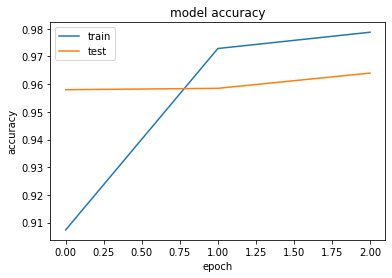

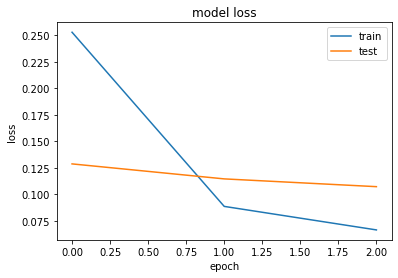

In [ ]:
import matplotlib.pyplot as plt

# Epocs plot for accuracy and loss
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
# Sklearn classification report with the test data
# Labels 0 = no depression, 1 = depression

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import keras


y_pred = model.predict(test_dataset.batch(2))['logits'] # Prediction logits
y_prob = tf.nn.softmax(y_pred) # Class probabilities
predictions = np.argmax(y_prob, axis = 1) # Final prediction

print(classification_report(y_test, predictions))
print(pd.DataFrame(confusion_matrix(y_test, predictions))) ### Hacerla bonita ###

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       962
           1       0.96      0.97      0.97      1038

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000

     0     1
0  918    44
1   28  1010


In [ ]:
# Function to predict one string at a time.
def predictOneSentence(text):
  tokentext = tokenizer([text], truncation=True, padding=True, max_length = 100) # Tokenizing text
  
  tensortext = tf.data.Dataset.from_tensor_slices(( # Turning text to TF tensor
    dict(tokentext),
    [0]
  ))
  
  logit = model.predict(tensortext.batch(2))['logits'] # Turning from logits to 0 or 1
  sm = tf.nn.softmax(logit)
  pred = np.argmax(sm, axis = 1)

  return pred[0]

In [ ]:
if predictOneSentence("I'm not able to do anything right. And I have no perspective that I will have a happy future. I think that my shit childhood was the best I will ever get from life.") == 0:
  print("happy")
else:
  print("sad")

sad


In [ ]:
if predictOneSentence("I learned of a kitchen life hack, tried it, and it really seems to be working") == 0:
  print("happy")
else:
  print("sad")

happy
